# Data Science Capstone - The Best Neighborhood in New York to open a restaurant supply store

## Introduction


### Business Problem
- The City of New York is famous for its excellent cuisine. It's food culture includes an array of international cuisines influenced by the city's immigrant history. 
 - Due to this influence, many restaurants are operational in the city catering to a wide variety of audience. This also means that there is a huge demand for the supply of items needed to run these restaurants.
 - In this analysis, we will discuss the optimal place to start a restaurant supply chain shop which can cater to maximum restaurants.
 

### Target Audience
The target audience for this problem is any client who would like to find the optimal location for opening a restaurant supply store.

## Data Collection

### Data Requirements:
1. We will need a list of New York neighborhoods along with longitude and latitude information.
We start by collecting data about New York which orimarily comprises of its Neighborhoods, Boroughs and the corresponding Latitude and Longitude information. Below link contains the required information -
https://geo.nyu.edu/catalog/nyu-2451-34572


2. We will need a list of all Restaurant Venues from all neighborhoods in New York
We use FOURSQUARE API to download all venues which are related to food from all neighborhoods in New York. https://api.foursquare.com

 - Venues related to food can be filtered by passing the category identifier obtained from website - https://developer.foursquare.com/docs/resources/categories
 

3. Combine all of those into a working Data Set to cluster and geo spatial map of the results showing the best neighborhood to open a Restaurant Supply Store in New York

Combining all of these disparate data sets will clearly demonstrate the following:
 - which neighborhoods in New York have clusters of like Restaurants
 - which neighborhood should the client target to open their new store.

Let's start by importing the required libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize


!pip install matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

from sklearn.cluster import KMeans

!pip install folium
import folium

     |████████████████████████████████| 94 kB 3.7 MB/s eta 0:00:011


First we need to obtain the data for New York which contains data such as Neighborhoods and Boroughs along with their respective Latitude and Longitude Information. As mentioned in the data requirements section, this data can be obtained using the URL https://geo.nyu.edu/catalog/nyu-2451-34572. Sometimes the geojson file might not download. Hence I have placed the file at the following location - https://cocl.us/new_york_dataset.

Now lets import the geojson file and construct our dataframe with required values.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [3]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


As we can see, the neighborhoods dataframe contains the relevant information we need to process and analyze data related to New York.

Next, we retrieve the coordinates of New York city using Geocoder.

In [4]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Next we plot the dataframe using coordinates to make sure that the data is in correct format.

In [5]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Since maps are not available in the note, attached is an image which shows the generated graph.

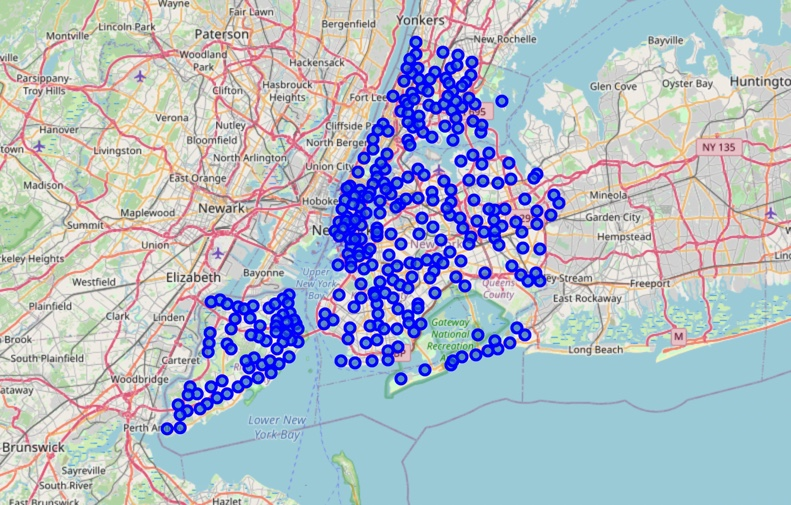

Below are the foursquare API credentials, but are hidden for security reasons

In [6]:
# @hidden_cell

#Foursquare credentials
CLIENT_ID = 'HKBVLXQIARURMUHI4TYR53P5TJYHEGRMUFY5ZUWCYBCSSDCL' # your Foursquare ID
CLIENT_SECRET = 'W5QFW43G31Q2ES2D1FHRWNUADHQET3INDNVIWFALRGNGHD41' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Below function retrieves the list of venues from Foursquare API using the dataframe we had constructed earlier

In [7]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

Next, we use the above function to retrieve the list of venues in New York which are related to food. This done by passing a variable called as "categoryId". This can be obtained from the Foursquare developer website as given below - https://developer.foursquare.com/docs/resources/categories.
The id for food is 4d4b7105d754a06374d81259.

In [8]:
#https://developer.foursquare.com/docs/resources/categories
#food = 4d4b7105d754a06374d81259
newyork_venues_food = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4d4b7105d754a06374d81259')
newyork_venues_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Margaritaville Restaurant and Lounge,40.898564,-73.837016,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Big Daddy's Caribbean Taste Restaurant,40.899767,-73.857135,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Fever Tropical Cuisine,40.892555,-73.857666,Comfort Food Restaurant


As we can see, the returned venues are all related to Food.